# **Tutorial: How AI Understands Text and Images** (Exercise)

**Objective:** In this tutorial, we will explore how modern AI models bridge the gap between two different modalities: Vision (Images) and Language (Text). We will focus on a groundbreaking model called **CLIP** (Contrastive Language-Image Pretraining), then examine a use case.

## **Hands-on with CLIP**
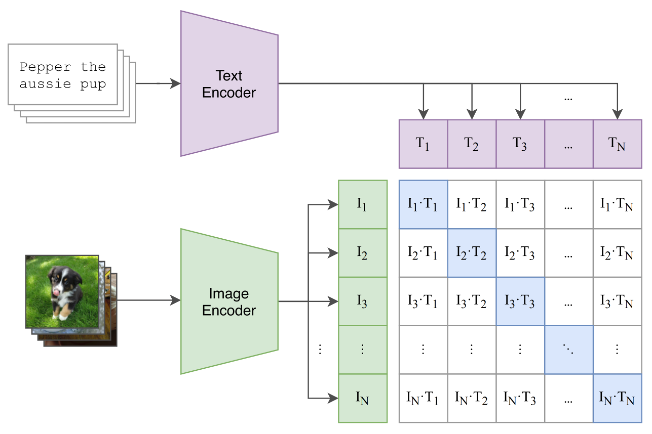

We will use the Hugging Face `transformers` library to load a pre-trained CLIP model and see how it **"understands"** your own text and images!

#### **Step 0 : Log In to Hugging Face in Colab**

https://huggingface.co/settings/tokens

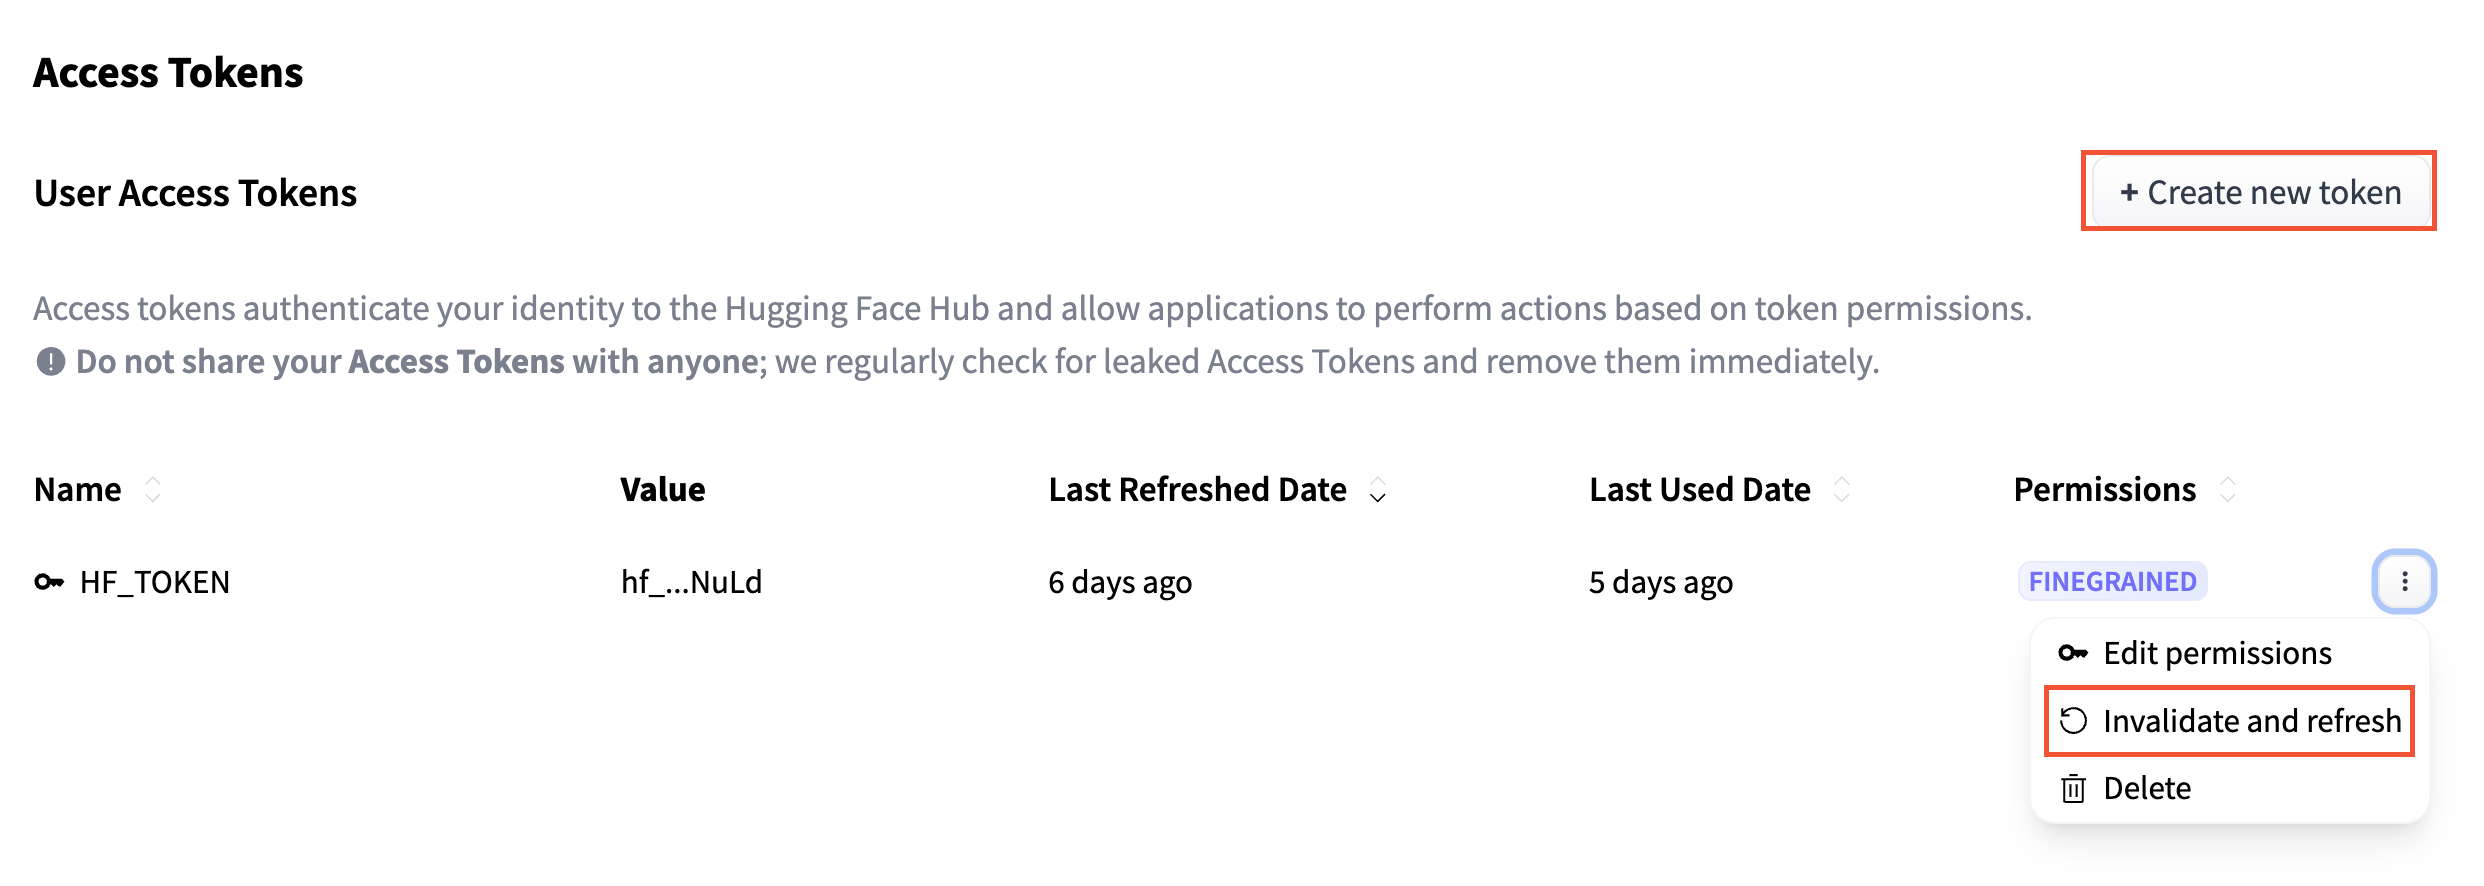


#### **Step 1 : Install Dependencies**
We need the transformers library (for the model) and pillow (for image processing)

In [ ]:
# !pip install transformers torch pillow matplotlib

In [ ]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from google.colab import files
import io

print("Libraries installed and imported!")

Libraries installed and imported!


#### **Step 2: Load the Pre-trained CLIP Model**

We are using `openai/clip-vit-base-patch32`, a lighter version of the model suitable for tutorials.

In [ ]:
print("Loading model... this may take a minute...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("Model loaded successfully!")

Loading model... this may take a minute...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
# If model loading fails, clear HF cache
import os
import shutil

hf_cache_home = os.path.expanduser("~/.cache/huggingface")

if os.path.exists(hf_cache_home):
    print(f"Clearing Hugging Face cache at: {hf_cache_home}")
    try:
        shutil.rmtree(hf_cache_home)
        print("Hugging Face cache cleared successfully.")
    except Exception as e:
        print(f"Error clearing cache: {e}")
else:
    print("Hugging Face cache directory not found. No cache to clear.")

print("Please restart your Colab runtime (Runtime > Restart runtime) and try loading the model again.")

Clearing Hugging Face cache at: /root/.cache/huggingface
Hugging Face cache cleared successfully.
Please restart your Colab runtime (Runtime > Restart runtime) and try loading the model again.


#### **Step 3: Load an Image**

**Instructions:**
1. Go to a site like [Unsplash](https://unsplash.com/).
2. Search for an image you like.
3. **Right-click** on the image itself.\n
4. Select **"Copy Image Address"** (Chrome), **"Copy Image Link"** (Edge/Safari), or **"Copy Link Location"** (Firefox).
* *Note: Do not copy the URL from the browser address bar at the top. You need the direct link to the JPG/PNG file.*,
5. Paste the link into the `image_url` variable in the code cell below.

(*Tip: Try uploading a photo of a pet, a car, or a specific object.*)

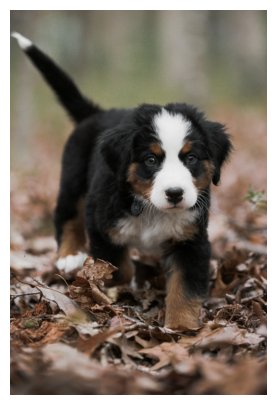

In [ ]:
image_url = 'https://images.unsplash.com/photo-1666212565787-8cd1d0075875?q=80&w=1587&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'

# Download the image
image = Image.open(io.BytesIO(requests.get(image_url).content))

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

#### **Step 4: Define Text Prompts**
How does the model perceive this image? Let's give it a few options (classes) and see which one creates an embedding closest to the image embedding.

Try modifying the `candidates` list below to include descriptions that might match your image, and some that definitely don't.

In [ ]:
# MODIFY THESE TEXTS to match what you want to test against your image
candidates = [
    "a walking cat",
    "a walking dog",
    "a baby mammal",
    "a delicious hamburger",
    "a diagram of a neural network",
    "someone studying hard"
]

# Process the inputs (Image + Text) into tensors
inputs = processor(text=candidates, images=image, return_tensors="pt", padding=True)

print(f"Inputs prepared. Comparison candidates: {candidates}")

Inputs prepared. Comparison candidates: ['a walking cat', 'a walking dog', 'a baby mammal', 'a delicious hamburger', 'a diagram of a neural network', 'someone studying hard']


#### **Step 5: Extract Embeddings**

We will now pass the inputs through the CLIP model to obtain the raw image and text embeddings.

These embeddings are vector representations of the image and text in a shared latent space and

what image and text actually look like to the machine.

In [ ]:
outputs = model(**inputs)

# Get the raw embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

print(f"Image Embedding Shape: {image_embeds.shape}")
print(f"Text Embedding Shape: {text_embeds.shape}")

print("\nFirst 10 values of the Image Embedding:")
print(image_embeds[0][:10])

print("\nFirst 10 values of the first Text Embedding:")
print(text_embeds[0][:10])

Image Embedding Shape: torch.Size([1, 512])
Text Embedding Shape: torch.Size([6, 512])

First 10 values of the Image Embedding:
tensor([ 0.0128,  0.0206, -0.0108,  0.0038,  0.0468, -0.0716,  0.0475,  0.0158,
        -0.0187,  0.0066], grad_fn=<SliceBackward0>)

First 10 values of the first Text Embedding:
tensor([-0.0013, -0.0326, -0.0120, -0.0312, -0.0097,  0.0388, -0.0313, -0.0700,
        -0.0278,  0.0186], grad_fn=<SliceBackward0>)


#### **Step 6: Compare Embeddings**

In [ ]:
import torch.nn.functional as F

# 1. Normalize the embeddings to unit vectors
normalized_image_embeds = F.normalize(image_embeds, p=2, dim=-1)
normalized_text_embeds = F.normalize(text_embeds, p=2, dim=-1)

# 2. Calculate cosine similarity by performing a matrix multiplication (dot product)
similarities = (normalized_image_embeds @ normalized_text_embeds.T)

# 3. Apply the softmax function to convert similarities into probabilities
probabilities = similarities.softmax(dim=1)

print(f"Similarities shape: {similarities.shape}")
print(f"Probabilities shape: {probabilities.shape}")


Similarities shape: torch.Size([1, 6])
Probabilities shape: torch.Size([1, 6])


#### **Step 7: Check out how CLIP understands the image and text candidates**

In [ ]:
import numpy as np

# Detach from tensor to numpy array for bar plot
probabilities_np = probabilities.detach().numpy()[0]

for i, candidate in enumerate(candidates):
  score = probabilities_np[i] * 100
  print(f"Probability of {candidate}: {score:.2f}%")

Probability of a walking cat: 16.75%
Probability of a walking dog: 17.63%
Probability of a baby mammal: 17.05%
Probability of a delicious hamburger: 16.38%
Probability of a diagram of a neural network: 16.03%
Probability of someone studying hard: 16.17%


In [ ]:
from sklearn.manifold import TSNE

# Prepare embeddings for scatter plot
norm_img_np = normalized_image_embeds.detach().cpu().numpy()
norm_text_np = normalized_text_embeds.detach().cpu().numpy()

# Combine image and text embeddings for t-SNE
all_embeds = np.vstack([norm_img_np, norm_text_np])

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000, learning_rate=200)
tsne_embeds = tsne.fit_transform(all_embeds)

# Separate the t-SNE results back into image and text components
tsne_image = tsne_embeds[0]
tsne_texts = tsne_embeds[1:]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


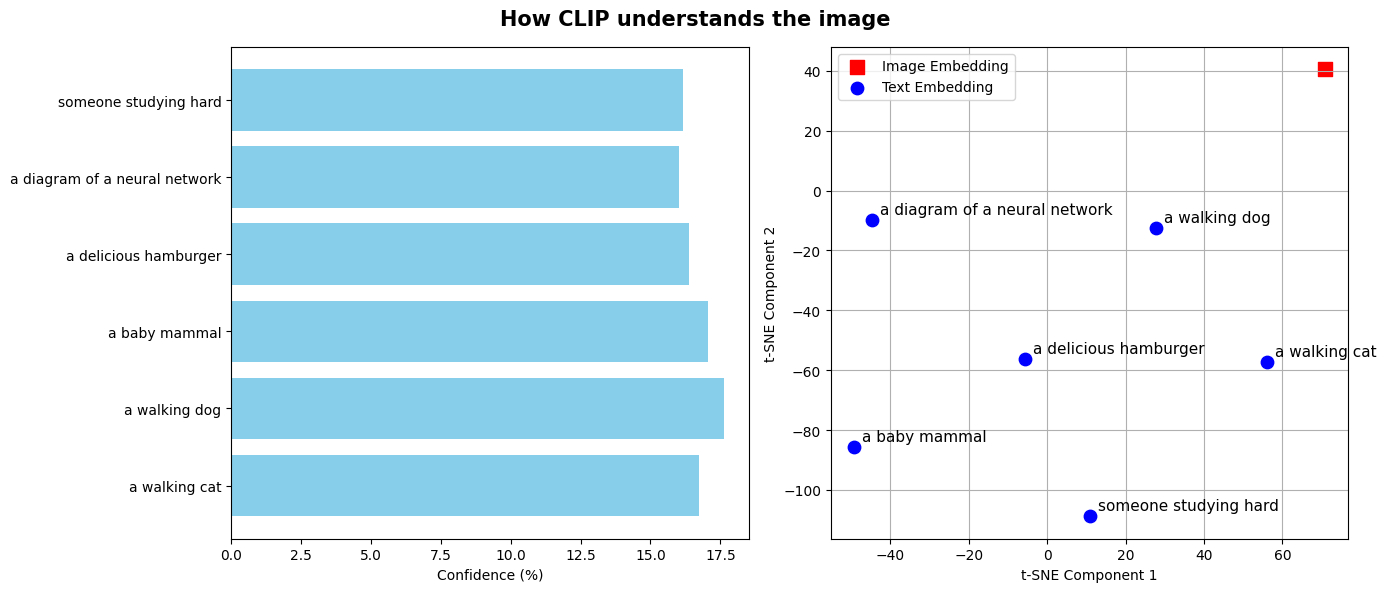

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle("How CLIP understands the image", fontsize=15, fontweight='bold')

# Subplot 1: Bar plot of probabilities
ax1 = axes[0]
ax1.barh(candidates, probabilities_np * 100, color='skyblue')
ax1.set_xlabel("Confidence (%)")

# Subplot 2: Scatter plot of t-SNE-reduced embeddings
ax2 = axes[1]
ax2.scatter(tsne_image[0], tsne_image[1], color='red', marker='s', s=100, label='Image Embedding')
for i, (x, y) in enumerate(tsne_texts):
    ax2.scatter(x, y, color='blue', marker='o', s=80, label='Text Embedding' if i == 0 else "") # Only label once
    ax2.text(x + 2, y + 2, candidates[i], fontsize=11)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

## **Use case: Retrieval**

#### **Retrieval vs. Search**

Traditional **Keyword Search** is trapped by exact matches—if your labels don't align perfectly with the query, you find nothing. For example, if you tagged an image "cat", you can only find it by searching "cat". **Semantic Retrieval** liberates you from metadata. By encoding the actual *meaning* of an image into a vector, embeddings allow you to search for abstract concepts, intent, or "vibes," retrieving results based on genuine relevance rather than rigid text matching.

Let’s see how this works through some real examples.

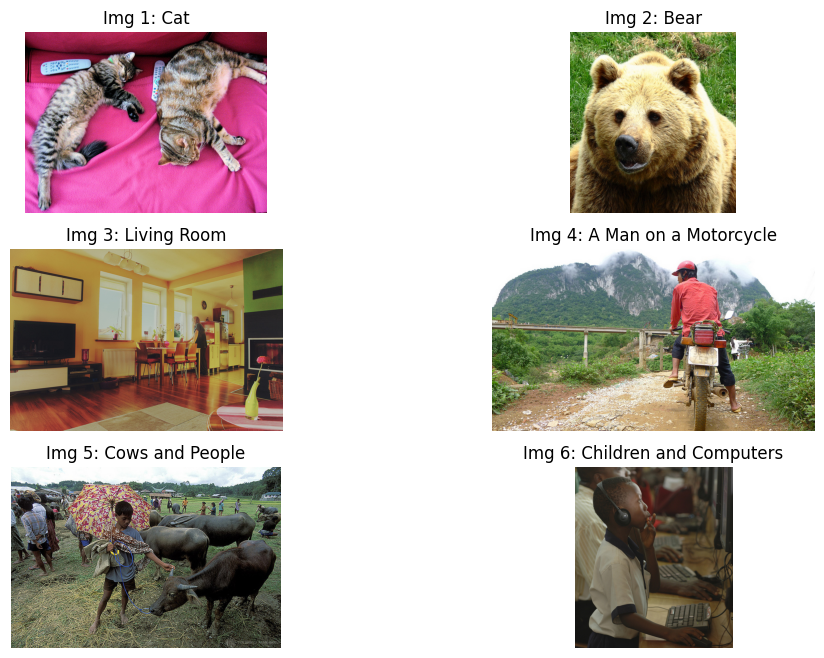

In [ ]:
# Download a few sample images to act as our Database

# Add your own image link found in the previous step
image_urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg", # Cat
    "http://images.cocodataset.org/val2017/000000000285.jpg", # Bear
    "http://images.cocodataset.org/val2017/000000000139.jpg", # Living Room
    "http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg", # A Man on a Motorcycle
    "http://images.cocodataset.org/val2014/COCO_val2014_000000184613.jpg", # Cows and People
    "http://images.cocodataset.org/val2014/COCO_val2014_000000318219.jpg"  # Children and Computers
]

image_labels = ["Cat", "Bear", "Living Room", "A Man on a Motorcycle", "Cows and People", "Children and Computers"]

gallery = []
for url in image_urls:
  gallery.append(Image.open(io.BytesIO(requests.get(url).content)))

fig, axes = plt.subplots(3, 2, figsize=(12,8))

# Flatten the axes array to iterate over individual subplots
axes_flat = axes.flatten()

for i, img in enumerate(gallery):
  axes_flat[i].imshow(img)
  axes_flat[i].axis("off")
  axes_flat[i].set_title(f"Img {i+1}: {image_labels[i]}")
plt.show()

Let's try searching for **"predator"** below.
* Notice that the model ranks the **Bear** highly, even though we never told it those are predators.
* It ranks the others poorly.
* This proves the embedding contains the *concept* of the image, not just a label.

In [ ]:
search_concept = "predator"

# Process the text and images in the gallery
inputs = processor(text=[search_concept], images=gallery, return_tensors="pt", padding=True)
outputs = model(**inputs)

# Calculate Similarity
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

## 1. Normalize the embeddings to unit vectors (for cosine similarity calculation)
normalized_image_embeds = F.normalize(image_embeds, p=2, dim=-1)
normalized_text_embeds = F.normalize(text_embeds, p=2, dim=-1)

## 2. Calculate cosine similarity by performing a matrix multiplication (dot product)
similarities = (normalized_text_embeds @ normalized_image_embeds.T)

## 3. Apply the softmax function to convert similarities into probabilities
probabilities = similarities.softmax(dim=1)
probabilities_np = probabilities.detach().numpy().flatten()

## 4. Display Ranks
print(f"Concept: {search_concept}")
print("-----------------------------------------")
for i, score in enumerate(probabilities_np):
  print(f"Rank {i+1}: {image_labels[i]} with {score*100:.2f}% confidence")


Concept: predator
-----------------------------------------
Rank 1: Cat with 16.97% confidence
Rank 2: Bear with 17.10% confidence
Rank 3: Living Room with 16.36% confidence
Rank 4: A Man on a Motorcycle with 16.60% confidence
Rank 5: Cows and People with 16.67% confidence
Rank 6: Children and Computers with 16.31% confidence


#### **Activity 1: Sensitivity Analysis to Text Granularity**

**Task**

1.   **Vary Text Query Granularities**: Construct multiple text queries for a set of fixed target images, ranging from Coarse (single, abstract keywords like "predator") to Fine-Grained (detailed, descriptive sentences like "A striped feline standing on a rock").
2.   **Quantify Retrieval Confidence**: For each query, use the provided model to calculate the similarity score between the text embedding and the image embeddings. Apply a Softmax function to derive the model's Confidence (%) for each image.
3.   **Analyze Sensitivity**: Compare the confidence scores and the ranking of the correct image across the different levels of text granularity.



In [ ]:
# Try defining your own queries
queries = [
    "Two mammals",
    "The smartest animal",
    "A house pet",
    "Striped four-legged mammal sitting comfortably on a pink sofa",
    "Two felines are lying comfortably on a bright pink couch, completely relaxed as they stretch out across the soft fabric. The cat on the left is a long, slender tabby with darker stripes, curled slightly with its front paws extended and its head resting sideways in a peaceful sleep."
]

inputs = processor(text=queries, images=gallery, return_tensors="pt", padding=True)
outputs = model(**inputs)

image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

normalized_image_embeds = F.normalize(image_embeds, p=2, dim=-1)
normalized_text_embeds = F.normalize(text_embeds, p=2, dim=-1)

similarities = (normalized_text_embeds @ normalized_image_embeds.T)
probabilities = similarities.softmax(dim=1)

# Iterate through each query and its corresponding probabilities
for query_idx, query in enumerate(queries):
  print(f"Query: {query}")
  print("-----------------------------------------")
  # Get the probabilities for the current query (row)
  query_probabilities_np = probabilities[query_idx].detach().numpy()

  # Sort the image labels by probability for this query
  ranked_images_for_query = []
  for img_idx, score in enumerate(query_probabilities_np):
      ranked_images_for_query.append((score, image_labels[img_idx]))

  ranked_images_for_query.sort(key=lambda x: x[0], reverse=True)

  for rank, (score, label) in enumerate(ranked_images_for_query):
    print(f"Rank {rank+1}: {label} with {score*100:.2f}% confidence")
  print("\n")

Query: Two mammals
-----------------------------------------
Rank 1: Cat with 17.64% confidence
Rank 2: Bear with 17.03% confidence
Rank 3: Cows and People with 16.69% confidence
Rank 4: Living Room with 16.45% confidence
Rank 5: A Man on a Motorcycle with 16.38% confidence
Rank 6: Children and Computers with 15.81% confidence


Query: The smartest animal
-----------------------------------------
Rank 1: Bear with 17.32% confidence
Rank 2: Cat with 16.98% confidence
Rank 3: Cows and People with 16.84% confidence
Rank 4: Living Room with 16.38% confidence
Rank 5: Children and Computers with 16.29% confidence
Rank 6: A Man on a Motorcycle with 16.19% confidence


Query: A house pet
-----------------------------------------
Rank 1: Cat with 17.18% confidence
Rank 2: Bear with 17.16% confidence
Rank 3: Living Room with 17.04% confidence
Rank 4: Cows and People with 16.67% confidence
Rank 5: A Man on a Motorcycle with 16.06% confidence
Rank 6: Children and Computers with 15.88% confidence



#### **Activity 2: Embedding Space Visualization**

**Task**


1.   **Print Similarity Matrix**: Calculate and display the $\text{N} \times \text{M}$ similarity matrix, where $\text{N}$ is the number of image embeddings and $\text{M}$ is the number of text embeddings (i.e., the candidate labels).
2.   **Visualize with t-SNE**: Use t-SNE to project all embeddings from their high-dimensional space (e.g., 512-D) down to a 2-D coordinate plane.
3.   **Analyze Structure**: Examine the resulting t-SNE plot to interpret the spatial relationships between the points.



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


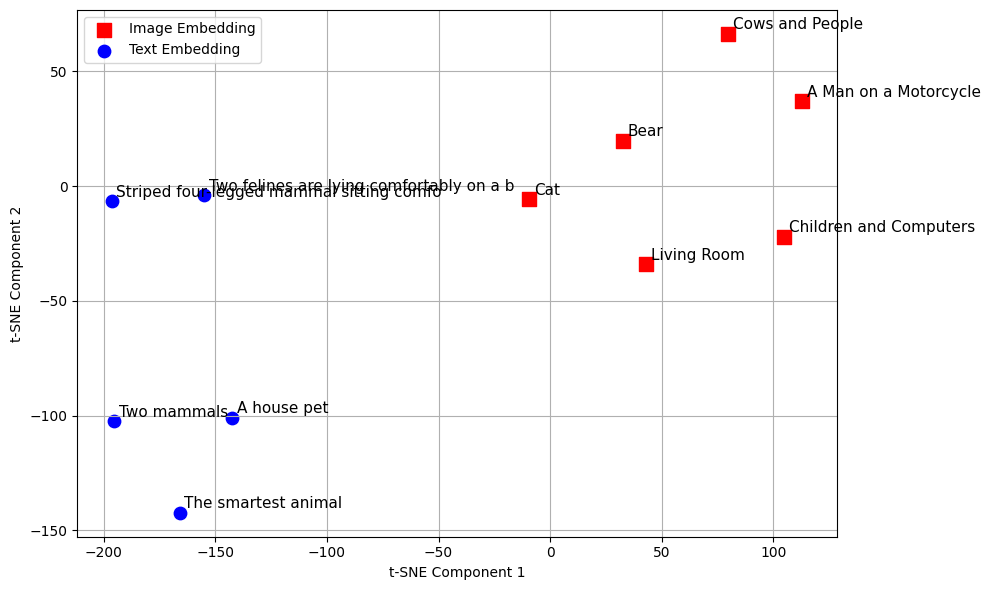

In [ ]:
# Calculate the similarity matrix
# similarity_matrix = (gallery_embeds @ gallery_embeds.T).detach().numpy() --What would be the dimension of this matrix?

# Apply t-SNE
norm_img_np = normalized_image_embeds.detach().cpu().numpy()
norm_text_np = normalized_text_embeds.detach().cpu().numpy()

# Combine image and text embeddings for t-SNE
all_embeds = np.vstack([norm_img_np, norm_text_np])

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000, learning_rate=200)
tsne_embeds = tsne.fit_transform(all_embeds)

# Separate the t-SNE results back into image and text components
# Correct slicing based on the actual number of images (len(image_labels)) and queries (len(queries))
tsne_images = tsne_embeds[0:len(image_labels)]
tsne_texts = tsne_embeds[len(image_labels):]

# Visualization
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(tsne_images):
    plt.scatter(x, y, color='red', marker='s', s=100, label='Image Embedding' if i == 0 else "")
    plt.text(x + 2, y + 2, image_labels[i], fontsize=11)
for i, (x, y) in enumerate(tsne_texts):
    plt.scatter(x, y, color='blue', marker='o', s=80, label='Text Embedding' if i == 0 else "") # Only label once
    plt.text(x + 2, y + 2, queries[i][:40], fontsize=11)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

# **Assignment** ⛄️

In this assignment, you will explore how multimodal models—specifically **CLIP**—represent images and text in a shared embedding space. You will experiment with retrieval, evaluate similarity-based reasoning.

Create a small multimodal dataset by selecting 10 pairs of images and corresponding text descriptions of your choice. Try to vary the text length and granularity (short captions, long descriptions, detailed vs. abstract).

Use CLIP to extract image and text embeddings for your dataset.
Compute a similarity matrix between all image–text combinations.

### **Experiments**
*   **(a) Retrieval**: Using your similarity matrix, print the matrix and report the **ranked list of images** based in similarity for each text query.
*   **(b) Similarity as Context for LLMs**: Use an LLM to answer questions about your dataset under two conditions. Choose **3 random image–text pairs** as context and ask the model any reasonable questions(e.g., *Which image best matches each text description? Explain your reasoning.*). You may use the WebUI LLM (https://gemini.google.com/app) for this experiment. Record and share the model’s responses. Run two variations:

    *   **Image-text Only**: Provide only the 3 image–text pairs.
    *   **Image-text + Similarities**: Provide the 3 image–text pairs plus the similarity scores (matrix) between the texts and images.


### **Analysis**
*   **(Required)** Explain how differences in text detail or abstraction affected CLIP’s similarity scores.
*   **(Required)** Analyze how adding similarity information changed the LLM’s reasoning or answers.
*   **(Optional)** What does “understanding” mean, and how does machine understanding differ from human understanding? Based on your own learning experiences, discuss this distinction and propose ways to better align machine “understanding” with human understanding, especially given that embeddings are learned through specific training objectives.

